# Wolff Algorithm and Broad Histogram method for 3D Heisenberg Model

## Packages

In [1]:
try:
    from tqdm.notebook import tqdm as tq
except:
    !pip install tqdm
    from tqdm.notebook import tqdm as tq

import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numba as nb
import seaborn as sns
import pandas as pd
from numba import prange
import time
from tqdm.notebook import tqdm as tq

rcParams.update({'font.size': 11.5})

# General functions

## Initilization and neighbors

In [2]:
@nb.njit
def random_initialize(L):
    """Generates a random initialization of the spins lattice.
    Args:
        L (int): Length of the lattice
    Returns:
        S (array): (L^3 x 3) array where each row represents a spin and each column contains
                    its components in x, y and z.
    """
    N = L**3
    S = np.zeros((N,3))
    PHI = np.random.uniform(0, 2*np.pi, N)
    THETA = np.random.uniform(0, np.pi, N)
    Sx = np.sin(THETA)*np.cos(PHI)
    Sy = np.sin(THETA)*np.sin(PHI)
    Sz = np.cos(THETA)
    S[:,0], S[:,1], S[:,2] = Sx, Sy, Sz 
    return S

def get_neighbors(L):
    """
    Args:
        L (int): Length of the lattice
    Returns:
        nbr (array): (L^3 x 6) array where each row represents a spin and each column the
                    the index of its neighbors.
    """
    N = L**3
    nbr = np.zeros((N,6),dtype=np.int32)
    for i in range(N):
        nbr[i,:] = [(i // L) * L + (i - 1) % L, (i // L) * L + (i + 1) % L,
               (i + L) % N, (i - L) % N, (i + L**2) % N, (i - L**2) % N]
    return nbr

## Thermodynamic quantities

In [3]:
@nb.njit
def calculate_energy(S, nbr):
    """
    Args:
        S (array): Lattice
        nbr (array): Neighbors
    Returns:
        E (float): Energy
    """
    N = S.shape[0]
    E = 0
    for i in prange(N):
        nbrs_i = nbr[i]
        S_i = S[i]
        for ii in nbrs_i:
            E += -np.dot(S[ii], S_i)
    E = E/2
    return E

@nb.njit
def calculate_magnet(S):
    """
    Args:
        S (array): Lattice
    Returns:
        M (float): Magentization calculated as the norm of the sum of all spin vectors
    """
    N = S.shape[0]
    S_sum = np.sum(S, axis=0)
    return 1/N*np.linalg.norm(S_sum)

In [4]:
def test_calculate_energy(L):
    nbr = get_neighbors(L)
    S = random_initialize(L)
    E = calculate_energy(S, nbr)
    print('Energy1 = ', E)
    S = np.zeros((L**3,3))
    S[:,0] = 1
    E = calculate_energy(S, nbr)
    print('Energy2 =', E)

test_calculate_energy(10)

Energy1 =  50.514957658442384
Energy2 = -3000.0


# Wolff Clusters Algorithm

In [5]:
@nb.njit
def p_acc(T, r, s_i, s_j):
    """
    Args:
        T (float): Temperature
        r (array): Random vector along which the cluster will be flipped
        s_i (array): Spin i
        s_j (array): Spin j (neighbor to add/reject)
    Returns:
        p (float): Probability of accepting a neighboring spin in the cluster
    """
    beta = 1/T
    p = 1-np.exp(min(0,-2*beta*(np.dot(r, s_i))*np.dot(r, s_j))) 
    return p

@nb.njit
def add_neighbors(neighbors, j, T, r, S, Pocket, Cluster):
    """
    Args:
        T (float): Temperature
        r (array): Random vector along which the cluster will be flipped
        s_i (array): Spin i
        s_j (array): Spin j (neighbor to add/reject)
    Returns:
        p (float): Probability of accepting a neighboring spin in the cluster
    """
    for ii in range(neighbors[j].shape[0]):
        l = int(neighbors[j][ii])
        p = p_acc(T, r, S[j,:], S[l,:])
        if (l not in Cluster) and np.random.random() < p:
            Pocket = np.append(Pocket, l)
            Cluster = np.append(Cluster, l)
    return Pocket, Cluster

@nb.njit
def generate_and_flip_cluster(S, neighbors, k, T, r):
    Pocket, Cluster = np.array([k], dtype=np.int32), np.array([k], dtype=np.int32)
    while Pocket.shape[0] != 0:
        index_j = np.random.randint(0, Pocket.shape[0])
        j = int(Pocket[index_j])
        Pocket, Cluster = add_neighbors(neighbors, j, T, r, S, Pocket, Cluster)
        Pocket = np.delete(Pocket, index_j)
    for i in Cluster:
        S[i] = S[i] - 2*np.dot(S[i], r)*r
    return S

@nb.njit
def cluster_sample(S, nbr, T, n_flips):
    N = S.shape[0] # Total number of spins
    # Generate cluster configuration with n_flips
    for step in range(n_flips):       
        # Random vector r
        theta = 2*np.pi*np.random.random()
        phi = np.pi*np.random.random()
        r = np.array([np.sin(theta)*np.cos(phi),
                      np.sin(theta)*np.sin(phi),
                      np.cos(theta)])
        
        # Generate and flip cluster at site k
        k = np.random.randint(0, N)
        S = generate_and_flip_cluster(S, nbr, k, T, r)
    return S

In [6]:
@nb.njit
def thermo_T(S, nbr, T, n_samples):
    """Calculates the thermodynamic quantities at a given temperature
    Args:
        S (array)
        nbr (array)
        T (float): Temperature > 0
        n_samples (int): Number of values to calculate
    Returns:
        M (float): Magnetization
    """
    M = 0
    n_flips = 1000
    if T < 1.45:
        n_flips = 10
    for i in range(n_samples):
        S = cluster_sample(S, nbr, T, n_flips) 
        M += calculate_magnet(S)
    M = M/n_samples
    return M

In [7]:
n_temps = 40 # Number of temperature values 
T_vals = np.linspace(2.5, 0.5, n_temps)
M = np.zeros(n_temps)
L = 10
S = random_initialize(L)
nbr = get_neighbors(L)
t = tq(range(n_temps))
for ii in t:
    n_samples = 300 # Number n of samples for calculating the thermal average
    M[ii] = thermo_T(S, nbr, T_vals[ii], n_samples)
    t.set_description("T = {:.3f} : ".format(T_vals[ii]))

  0%|          | 0/40 [00:00<?, ?it/s]

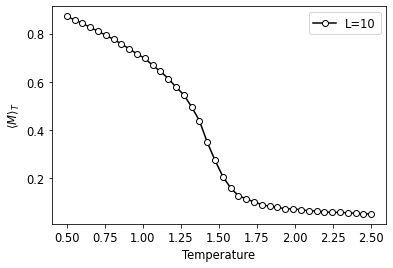

In [8]:
plt.plot(T_vals,M,'ko-',mfc='w',label='L={}'.format(L))
plt.xlabel('Temperature')
plt.ylabel(r'$\langle M\rangle_T$')
plt.legend()
# plt.savefig('L_{}.jpg'.format(L), bbox_inches='tight')

# Broad Histogram Method

## Energize and rotate spin

In [9]:
@nb.njit
def get_angles(vector):
    """
    Args:
        vector (array)
    Returns:
        theta (float): Polar angle (z axis) 
        phi (float): Azimuth angle
    """
    r = np.linalg.norm(vector)
    x, y, z = vector[0], vector[1], vector[2]
    theta = np.arccos(z/r)
    if theta == 0:
        phi = 0
    else:
        phi = np.arccos(x/(r*np.sin(theta)))
        phi = np.arctan2(y,x)
    return theta, phi

In [10]:
def energize(S, nbr, E_target, tol, max_iter):
    """
    Args:
        S (array)
        nbr (array)
        E_target (float)
        tol (float)
        max_iter (int)
    Returns:
        S (array): Energized configuration
        E_current: Energy 
    """
    N = S.shape[0]
    M = 0
    E_current = calculate_energy(S, nbr)
    DeltaE = abs(E_target - E_current)
    while DeltaE > tol and M <= max_iter:
        k = np.random.randint(0, N)
        S_k = S[k]
        A_k = np.sum(S[nbr[k]],axis=0)
        Anorm = np.linalg.norm(A_k)
        theta, phi = get_angles(A_k)
        alpha = np.pi/2 - phi
        beta = -theta
        Rotz = np.array([[np.cos(alpha), -np.sin(alpha), 0],
                        [np.sin(alpha), np.cos(alpha), 0],
                        [0, 0, 1]])
        Rotx = np.array([[1, 0, 0],
                        [0, np.cos(beta), np.sin(beta)],
                        [0, -np.sin(beta), np.cos(beta)]])
        Rot = np.dot(Rotx, Rotz)
        ei_old = -np.dot(S_k, A_k)
        z = -ei_old/Anorm
        if E_current < E_target:
            z = np.random.uniform(-1, z)
        else:
            z = np.random.uniform(z, 1)
        theta = np.arccos(z)
        phi = np.random.uniform(0, 2*np.pi)
        sk_new = np.array([[np.sin(theta)*np.cos(phi)],
                           [np.sin(theta)*np.sin(phi)],
                           [np.cos(theta)]])
        sk_new = np.reshape(np.dot(Rot.T, sk_new), A_k.shape)
        ei_new = - np.dot(sk_new, A_k)
        S[k] = sk_new
        DE = ei_new - ei_old
        E_current += DE
        DeltaE = abs(E_target-E_current)
        M += 1
    return S, E_current

In [11]:
def test_energize(L, tol=0.01):
    print('Tolerance is ', tol)
    print('................................')
    for i in range(5):
        S = random_initialize(L)
        nbr = get_neighbors(L)
        E_desired = np.random.uniform(-L**3, L**3)
        E_before = calculate_energy(S, nbr)
        print('E_before = ', E_before)
        S, E_after = energize(S, nbr, E_desired, tol, 10000)
        print('E_desired = ', E_desired)
        print('E_after = ', E_after)
        print('................................')
        
test_energize(10, 0.001)

Tolerance is  0.001
................................
E_before =  -6.208249711194377
E_desired =  -452.12107033020584
E_after =  -452.12179378941494
................................
E_before =  4.1789851955667325
E_desired =  762.2220526157794
E_after =  762.2227529984661
................................
E_before =  -9.648611693181126
E_desired =  -651.8552541152229
E_after =  -651.8551275450249
................................
E_before =  -59.431948111194
E_desired =  162.1664805425537
E_after =  162.1656727928952
................................
E_before =  19.095460127330465
E_desired =  -16.732071814003348
E_after =  -16.732754108567836
................................


In [12]:
def rotate_spin(S, nbr, index, E, Emin, Emax):
    DeltaEb = min(Emax-E, E-Emin)
    S_i = S[index]
    nbr_i = nbr[index]
    A_i = np.sum(S[nbr_i],axis=0)
    Anorm = np.linalg.norm(A_i)
    theta, phi = get_angles(A_i)
    alpha = np.pi/2 - phi
    beta = -theta
    Rotz = np.array([[np.cos(alpha), -np.sin(alpha), 0],
                    [np.sin(alpha), np.cos(alpha), 0],
                    [0, 0, 1]])
    Rotx = np.array([[1, 0, 0],
                    [0, np.cos(beta), np.sin(beta)],
                    [0, -np.sin(beta), np.cos(beta)]])
    Rot = np.dot(Rotx, Rotz)
    ei_old = -np.dot(S_i, A_i)
    ei_min = ei_old - DeltaEb
    ei_max = ei_old + DeltaEb
    zmin = max(-1, -ei_max/Anorm)
    zmax = min(1, -ei_min/Anorm)
    zrand = np.random.uniform(zmin, zmax)
    theta = np.arccos(zrand)
    phi_rand = np.random.uniform(0, 2*np.pi)
    si_new = np.array([[np.sin(theta)*np.cos(phi_rand)],
                       [np.sin(theta)*np.sin(phi_rand)],
                       [np.cos(theta)]])
    si_new = np.reshape(np.dot(Rot.T, si_new), A_i.shape)
    ei_new = -np.dot(si_new, A_i)
    S[index] = si_new
    DeltaE = ei_new - ei_old
    E += DeltaE 
    return S, ei_old, E, Anorm

In [13]:
def test_rotate_spin(L, Num):
    for i in range(Num):
        S = random_initialize(L)
        nbr = get_neighbors(L)
        N = S.shape[0]
        index = np.random.randint(0,N)
        DeltaEb = 2
        E_ini = calculate_energy(S, nbr)
        Emin = E_ini - DeltaEb
        Emax = E_ini + DeltaEb
        print('Emax =', Emax)
        print('Emin =', Emin)
        print('E_initial =', E_ini)
        num_true = 0
        E = E_ini
        for i in range(15):
            S, _, E, _ = rotate_spin(S, nbr, index, E, Emin, Emax)
            Efin = calculate_energy(S, nbr)
            num_true += Emin < Efin and Efin < Emax  
        print('E_final =', calculate_energy(S, nbr))
        print('Num_true out (/15) =', num_true)
        print('.............................................')
        
test_rotate_spin(10, 5)

Emax = 16.415092010943347
Emin = 12.415092010943347
E_initial = 14.415092010943347
E_final = 12.666528199847217
Num_true out (/15) = 15
.............................................
Emax = -0.21046367266479482
Emin = -4.210463672664795
E_initial = -2.210463672664795
E_final = -1.2004155137308772
Num_true out (/15) = 15
.............................................
Emax = 15.107006909241212
Emin = 11.107006909241212
E_initial = 13.107006909241212
E_final = 13.444917092734427
Num_true out (/15) = 15
.............................................
Emax = 2.8519060930246467
Emin = -1.1480939069753533
E_initial = 0.8519060930246467
E_final = 2.6258938438108377
Num_true out (/15) = 15
.............................................
Emax = 20.997473414792246
Emin = 16.997473414792246
E_initial = 18.997473414792246
E_final = 18.780327264995044
Num_true out (/15) = 15
.............................................


## Sampling

In [14]:
def one_energy(S, nbr, E, DeltaEb, DeltaE_fix , shuffle=True):
    """Calculate everything for a given energy at some T and E
    Args:
        S (array): Array of spins size (Nx3).
        nbr (array): Array containig the indices of the neighbors of each spin.
        E (float): Energy of interest.
        DeltaEb (float): Window for rotating the spins.
        DeltaE_fix (float): Fixed number for obtaining the N_up, N_down values.
        shuffle (bool): Random lattice sweep.
    Returns:
        N_up (float): Updated
        N_down (float): Updated
        Thermo (array): Updated
    """
    N = S.shape[0]
    indices = np.arange(N)
    if shuffle:
        np.random.shuffle(indices)
    N_up = 0
    N_down = 0
    Emin = E - DeltaEb
    Emax = E + DeltaEb
    for i in range(N):
        index = indices[i]
        S, ei_old, E, Ai_norm = rotate_spin(S, nbr, index, E, Emin, Emax)
        if abs(DeltaE_fix + ei_old) < Ai_norm:
            N_up += 1/N * 1/(2*Ai_norm)
        if abs(-DeltaE_fix + ei_old) < Ai_norm:
            N_down += 1/N * 1/(2*Ai_norm)
    return N_up, N_down

In [15]:
def one_muC(L, nbr, E_vals, DeltaEb, DeltaE_fix):
    """Samples across all energies in a given array.
    Args:
        L (int)
        E_vals (array)
        DeltaEb (float)
        DeltaE_fix (float)
        nbr (array)
    Returns:
        Nup (Array)
        Ndown (Array)
        Thermo (Array)
    """
    num_values =  E_vals.shape[0]
    Nup = np.zeros(num_values)
    Ndown = np.zeros(num_values)
    S = random_initialize(L)
    cluster_sample(S, nbr, 1.44, 300)
    for ii in prange(num_values):
        energy = E_vals[ii]
        cluster_sample(S, nbr, 1.44, 10)
        S, E_start = energize(S, nbr, energy, DeltaEb/5, 20000)
        Nup_ii, Ndown_ii = one_energy(S, nbr, energy, DeltaEb, DeltaE_fix, shuffle=True)
        Nup[ii] += Nup_ii
        Ndown[ii] += Ndown_ii
    return Nup, Ndown

## Main loop

In [16]:
num_values = 120
E_vals = np.linspace(-2700, 0, num_values, endpoint=False)
Nup = np.zeros(num_values)
Ndown = np.zeros(num_values)
total_runs = 10
L = 10
nbr = get_neighbors(L)
DeltaEb = 2
DeltaE_fix = 1
for i in tq(range(total_runs)):
    Nup_i, Ndown_i = one_muC(L, nbr, E_vals, DeltaEb, DeltaE_fix)
    Nup += Nup_i
    Ndown += Ndown_i
Nup = Nup/total_runs
Ndown = Ndown/total_runs

  0%|          | 0/10 [00:00<?, ?it/s]

# Plotting

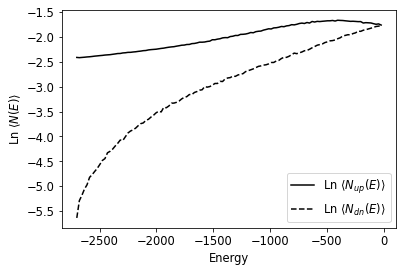

In [17]:
plt.plot(E_vals, np.log(Nup),'k-', label=r'Ln $\langle N_{up}(E)\rangle$')
plt.plot(E_vals, np.log(Ndown),'k--', label=r'Ln $\langle N_{dn}(E)\rangle$')
plt.ylabel(r'Ln $\langle N(E)\rangle$')
plt.xlabel(r'Energy')
plt.legend()
# plt.savefig('Log.jpg',dpi=400,bbox_inches='tight')

Text(0, 0.5, '$\\beta(E)$')

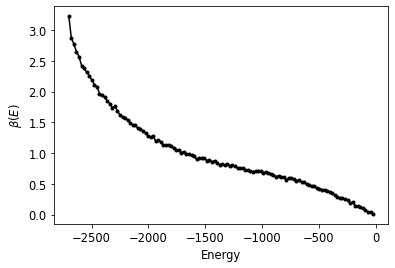

In [18]:
beta = 1/DeltaE_fix * np.log(Nup/Ndown)
plt.plot(E_vals, beta,'k.-')
plt.xlabel(r'Energy')
plt.ylabel(r'$\beta(E)$')
# plt.savefig('beta.jpg',dpi=400,bbox_inches='tight')